In [1]:
%cd ..

C:\Users\Brown Research\Documents\vr-exoskeleton


# autoregressive

In [2]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation

from vr_exoskeleton import data_utils, gaze_modeling

In [3]:
def load_user(path):
    df = pd.read_csv(path)
    df.drop(columns=['time(100ns)', 'time_stamp(ms)', 'frame'], inplace=True)
    df['eye_in_head_left_x'] = -df['eye_in_head_left_x']
    df['eye_in_head_right_x'] = -df['eye_in_head_right_x']
    df['head_x'] = -df['head_x']  # Counteract C# scale by 'new Vector3(-1, 1, 1)'.
    df['eye_in_head_left_origin_x'] = -df['eye_in_head_left_origin_x']
    df['eye_in_head_right_origin_x'] = -df['eye_in_head_right_origin_x']
    return df


def load_obj(path):
    df = pd.read_csv(path)
    df.drop(columns=['time(100ns)', 'time_stamp(ms)'], inplace=True)
    return df


users = ['2025040302', '2025041602', '2025042201']
tasks = ['LinearSmoothPursuit', 'ArcSmoothPursuit', 'RapidVisualSearch', 'RapidVisualSearchAvoidance']
n_trials = 3

user_task_paths = dict()
user_task_paths_obj = dict()
for user in users:
    user_task_paths[user] = dict()
    user_task_paths_obj[user] = dict()
    folder_user = os.path.join('..', 'EyeAndNeckTracking', 'Data', 'Users', user)
    for task in tasks:
        user_task_paths[user][task] = list()
        user_task_paths_obj[user][task] = list()
        for trial in range(n_trials):
            fname = f'User{user}_{task}_{trial:d}.csv'
            path = os.path.join(folder_user, fname)
            df = load_user(path)
            user_task_paths[user][task].append(path)

            fname_obj = f'Object{user}_{task}_{trial:d}.csv'
            path_obj = os.path.join(folder_user, fname_obj)
            df_obj = load_obj(path_obj)
            user_task_paths_obj[user][task].append(path_obj)

user_task_paths[users[0]][tasks[0]][0]

'..\\EyeAndNeckTracking\\Data\\Users\\2025040302\\User2025040302_LinearSmoothPursuit_0.csv'

In [10]:
def _vector(df, name, sep, dims):
    cols = [f'{name}{sep}{axis}' for axis in dims]
    return df[cols].to_numpy()


def vector3(df, name, sep='_'):
    return _vector(df, name, sep, ('x', 'y', 'z'))


def vector_rotation(df, name, sep='_'):
    return _vector(df, name, sep, ('x', 'y', 'z', 'w'))

In [11]:
user_to_eye_left_origin = {
    # '2025040302': np.array([ 0.03532695, 0.00364703, -0.02478334]),
    # '2025041602': np.array([ 0.031268, -0.00073946, -0.02363204]),
    # '2025042201': np.array([ 0.03211912, -0.00299114, -0.02772827])
    '2025040302': np.array([-0.03532695, 0.00364703, -0.02478334]),
    '2025041602': np.array([-0.031268, -0.00073946, -0.02363204]),
    '2025042201': np.array([-0.03211912, -0.00299114, -0.02772827])
}
user_to_eye_right_origin = {
    # '2025040302': np.array([-0.030932, -0.00060822, -0.02428921]),
    # '2025041602': np.array([-0.03364768, -0.00047236, -0.02439187]),
    # '2025042201': np.array([-0.0298891, 0.00264301, -0.02789513])
    '2025040302': np.array([ 0.030932, -0.00060822, -0.02428921]),
    '2025041602': np.array([ 0.03364768, -0.00047236, -0.02439187]),
    '2025042201': np.array([ 0.0298891, 0.00264301, -0.02789513])
}

In [15]:
def get_coefficients_foci(df, user):
    # Calculate ray of focal point.
    # p_l = vector3(df, 'eye_in_world_left_origin')  # p1 - left eye origin
    # p_r = vector3(df, 'eye_in_world_right_origin')  # p2 - right eye origin
    # g_l = vector3(df, 'eye_in_world_left')  # d1 - left eye direction
    # g_r = vector3(df, 'eye_in_world_right')  # d2 - right eye direction
    
    # h_x, h_y, h_z = np.transpose(vector3(df, 'head'))
    # hypot = np.sqrt(h_y ** 2 + h_z ** 2)
    # q = Rotation.from_rotvec([-np.arctan2(h_y, h_z), np.arctan2(hypot, h_x), np.zeros(h_x.shape)])
    q = Rotation.from_quat(vector_rotation(df, 'head_rotation'))
    
    # p_l_h = vector3(df, 'eye_in_head_left_origin')
    # p_r_h = vector3(df, 'eye_in_head_right_origin')
    head_origin = vector3(df, 'head_origin')
    eye_left_origin = user_to_eye_left_origin[user]
    eye_right_origin = user_to_eye_right_origin[user]
    p_l = q.apply(eye_left_origin[np.newaxis, :]) + head_origin
    p_r = q.apply(eye_right_origin[np.newaxis, :]) + head_origin

    g_l = q.apply(vector3(df, 'eye_in_head_left'))
    g_r = q.apply(vector3(df, 'eye_in_head_right'))
    
    g_f = np.cross(g_l, g_r, axis=1)  # d3 - focal segment (perpendicular to both gaze rays) direction
    norm_f = np.linalg.norm(g_f, axis=1)[:, np.newaxis]
    g_f /= norm_f

    # Solve for lengths of rays.
    A = np.transpose([g_l, -g_r, g_f], (1, 2, 0))
    b = p_r - p_l
    c_l, c_r, c_f = np.transpose(np.linalg.solve(A, b))

    p_f = p_l + c_l[:, np.newaxis] * g_l
    assert np.allclose(p_f + c_f[:, np.newaxis] * g_f, p_r + c_r[:, np.newaxis] * g_r)

    c_f_half = c_f / 2
    return c_l, c_r, c_f, p_f + c_f_half[:, np.newaxis] * g_f


def mask_not_blinking(df_):
    return (df_['eye_in_head_left_z'] != 0.0) & (df_['eye_in_head_right_z'] != 0.0)


In [32]:
def error_angle(v1, v2):
    return np.arccos(np.sum(v1 * v2))


def gaze_radius_bounded(g):
    # solve (x^2/0.5) + ((y+0.1)^2)/0.5 = 1
    norm_z = np.sqrt(g[0] ** 2 + (g[1] + 0.1) ** 2)
    m = min(0.5, norm_z) / norm_z
    g_b = g.copy()
    g_b[0] = m * g_b[0]
    g_b[1] = m * (g_b[1] + 0.1) - 0.1
    g_b[2] = max(0.825, g_b[2])
    return g_b / np.linalg.norm(g_b)


def autoregressive(model, focus_on_object=False, downsampling_rate=1):
    i_print = 0
    # TODO: Add stochasticity to either focal point.
    user_task_losses = dict()
    user_task_trajs = dict()
    for user in users:
        user_task_losses[user] = dict()
        user_task_trajs[user] = dict()
        for task in tasks:
            # Begin trial.
            trial_losses = list()
            trajs = list()
            paths = user_task_paths[user][task]
            paths_obj = user_task_paths_obj[user][task]
            for path, path_obj in zip(paths, paths_obj):
                df = load_user(path)
                X_head_origin = vector3(df, 'head_origin')
                X_gaze_l = vector3(df, 'eye_in_head_left')
                X_gaze_r = vector3(df, 'eye_in_head_right')
                Y_head = vector3(df, 'head')
                # break

                if focus_on_object:
                    df_obj = load_obj(path_obj)
                    X_obj = vector3(df_obj, 'object1', sep='.')
                else:
                    mask_open = mask_not_blinking(df)
                    _, _, _, foci = get_coefficients_foci(df[mask_open], user)
                    foci_open = data_utils.interpolate_points(foci, mask_open)
                    mask_front = np.greater(foci_open[:, 2], X_head_origin[:, 2])
                    X_obj = data_utils.interpolate_points(foci_open[mask_front], mask_front)

                for shift in range(downsampling_rate):
                    sel = slice(shift, None, downsampling_rate)
                    X_head_origin_ = X_head_origin[sel]
                    X_obj_ = X_obj[sel]
                    X_gaze_l_ = X_gaze_l[sel]
                    X_gaze_r_ = X_gaze_r[sel]
                    Y_head_ = Y_head[sel]
                    
                    kwargs = dict()
                    losses = list()
                    traj = list()
                    head = np.array([0, 0, 1])
                    eye_left_origin_init = user_to_eye_left_origin[user]
                    eye_right_origin_init = user_to_eye_right_origin[user]
                    for t, (x_head_origin, x_obj, y_head) in enumerate(zip(X_head_origin_, X_obj_, Y_head_)):
                        fx, fy, fz = head
                        q = Rotation.from_rotvec([-np.arctan(fy / fz), np.arctan(fx / fz), 0.])
                        
                        eye_left_origin = q.apply(eye_left_origin_init) + x_head_origin
                        gaze_l = x_obj - eye_left_origin
                        gaze_l /= np.linalg.norm(gaze_l)
                        gaze_l = q.apply(gaze_l, inverse=True)
                        gaze_l = gaze_radius_bounded(gaze_l)
                        
                        eye_right_origin = q.apply(eye_right_origin_init) + x_head_origin
                        gaze_r = x_obj - eye_right_origin
                        gaze_r /= np.linalg.norm(gaze_r)
                        gaze_r = q.apply(gaze_r, inverse=True)
                        gaze_r = gaze_radius_bounded(gaze_r)

                        x = np.concatenate([gaze_l, gaze_r, head])
                        X = x[np.newaxis, :]
                        with torch.no_grad():
                            X_ = torch.tensor(X, dtype=torch.float32)
                            Y_hat = model(X_, **kwargs)
                            if isinstance(Y_hat, tuple):
                                Y_hat, hn, cn = Y_hat
                                kwargs['h0'] = hn
                                kwargs['c0'] = cn
                        y_hat = Y_hat[0].numpy()
                        # print(y)

                        delta = Rotation.from_rotvec([-y_hat[0], y_hat[1], 0.])
                        head = delta.apply(head)

                        # loss = np.linalg.norm(y_head - head)
                        loss = error_angle(y_head, head)
                        # print(y_head, head, loss)
                        losses.append(loss)

                        traj.append(x)
                        # break

                    trial_losses.append(sum(losses) / len(losses))
                    trajs.append((np.array(traj), Y_head_, X_head_origin_, X_obj_, X_gaze_l_, X_gaze_r_))
                    # break

            user_task_losses[user][task] = trial_losses
            user_task_trajs[user][task] = trajs
            
    return user_task_losses, user_task_trajs

In [30]:
def plot_traj_3d(traj, traj_true=None, title=None):
    plt.close()
    fig = plt.figure(figsize=(12, 3.6))
    for i, dim in enumerate(['x', 'y', 'z']):
        plt.plot(range(len(traj)), traj[:, i], color=f'C{i:d}', label=dim)
    if traj_true is not None:
        for i, dim in enumerate(['x', 'y', 'z']):
            plt.plot(range(len(traj_true)), traj_true[:, i], color=f'C{i:d}', label=f'{dim}, true', linestyle='--')
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()


def plot_trial(trajs, model_name=None, show_constants=False):
    suffix = f' ({model_name})' if model_name is not None else ''

    if show_constants:
        plot_traj_3d(trajs[3], title='Object position')
    plot_traj_3d(trajs[0][:, 6:9], traj_true=trajs[1], title='Predicted & followed head direction' + suffix)
    plot_traj_3d(trajs[0][:, 0:3], traj_true=trajs[4], title='Left eye direction in head' + suffix)
    plot_traj_3d(trajs[0][:, 3:6], traj_true=trajs[5], title='Right eye direction in head' + suffix)


In [8]:
def load_weights(model, path_weights):
    weights = torch.load(path_weights, weights_only=True)
    model.load_state_dict(weights)

### MLP

In [33]:
mlp = gaze_modeling.GazeMLP()
# load_weights(mlp, 'output/runs/1745426038_mlp_90hz-angle-h_s49/val_best.pth')  # Negated head_x; true head 'x' is negated.
# load_weights(mlp, 'output/runs/1748387184_mlp_90hz-angle-h_s50/val_best.pth')  # ; predicted head 'x' is pushed to `1`.
load_weights(mlp, 'output/runs/1748389086_mlp_90hz-angle-h_s50/val_best.pth')  # Negated gaze_[lr]_x; head 'y' seems to be negated.

user_task_losses_mlp, user_task_trajs_mlp = autoregressive(mlp)
user_task_losses_mlp

{'2025040302': {'LinearSmoothPursuit': [0.17451384693552968,
   0.24645716287739908,
   0.15521304670590844],
  'ArcSmoothPursuit': [0.1938726694932426,
   1.0138302225259705,
   1.443554836419288],
  'RapidVisualSearch': [0.8766781108646521,
   1.03816486436101,
   0.48926872065817856],
  'RapidVisualSearchAvoidance': [0.8598207045225323,
   0.6268200368687246,
   0.5583252485310215]},
 '2025041602': {'LinearSmoothPursuit': [0.21316441649117795,
   0.24836318829970133,
   0.21843522431503884],
  'ArcSmoothPursuit': [0.23946782450871465,
   0.20935156816370967,
   0.22227488732365966],
  'RapidVisualSearch': [0.3971386865688779,
   0.34124629054005506,
   0.3661038443627328],
  'RapidVisualSearchAvoidance': [0.35703275004607965,
   0.32460317056570015,
   0.3491610998734265]},
 '2025042201': {'LinearSmoothPursuit': [0.1764193359387294,
   0.2220897214704047,
   0.28556836342580344],
  'ArcSmoothPursuit': [0.25730982095706845,
   0.3031336949501637,
   0.3167977361142513],
  'RapidVisua

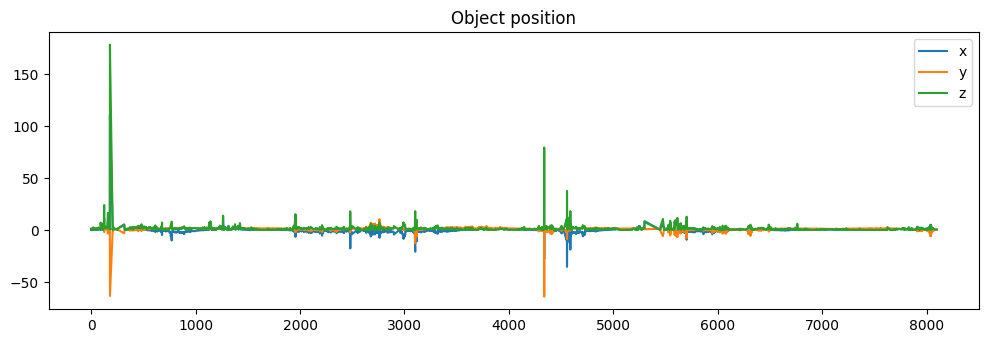

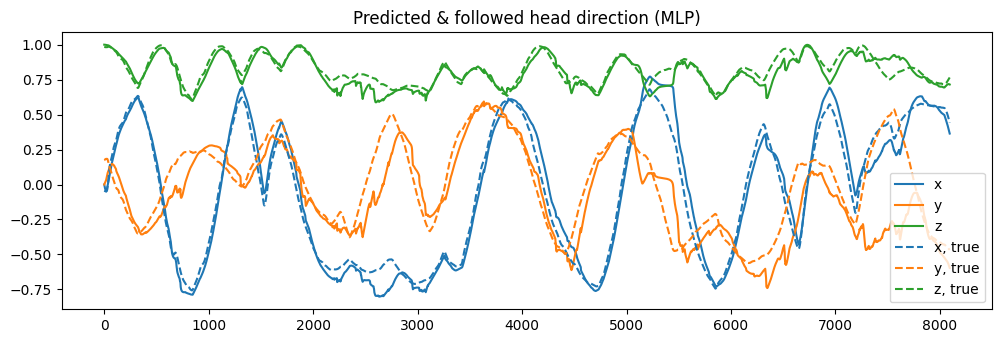

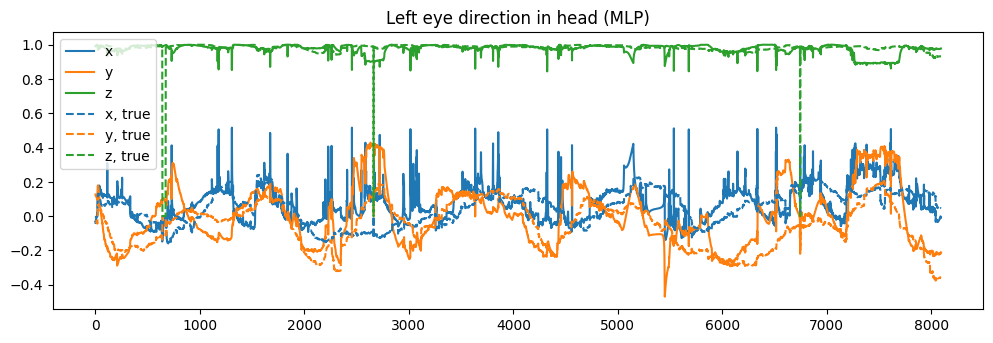

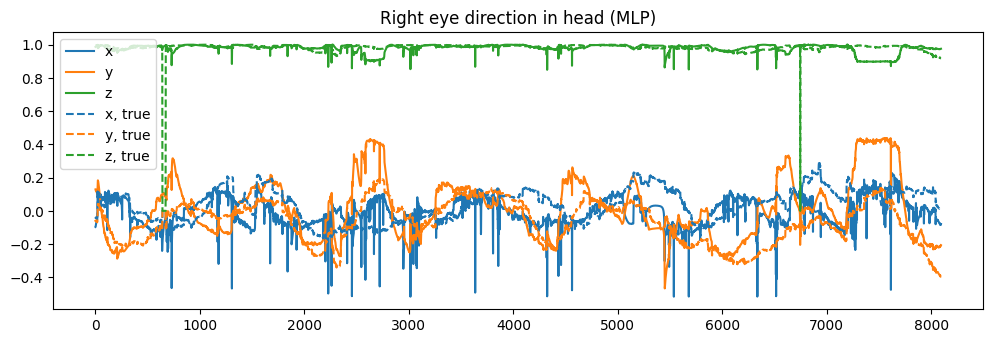

In [34]:
plot_trial(user_task_trajs_mlp[users[0]][tasks[0]][0], model_name='MLP', show_constants=True)

### MLP-H16_16

In [35]:
mlp2 = gaze_modeling.GazeMLP(hidden_sizes=[16, 16])
load_weights(mlp2, 'output/runs/1748536703_mlp_90hz-angle-h16_16_s50/val_best.pth')

user_task_losses_mlp2, user_task_trajs_mlp2 = autoregressive(mlp2)
user_task_losses_mlp2

{'2025040302': {'LinearSmoothPursuit': [0.2084695402017496,
   0.8636756628431612,
   0.1353436099002153],
  'ArcSmoothPursuit': [0.2117892101860934,
   0.9172128689681862,
   0.8998034055788341],
  'RapidVisualSearch': [0.8561057538574335,
   1.0876557362102433,
   0.5373180745262416],
  'RapidVisualSearchAvoidance': [0.6123924597781244,
   0.6335360590770585,
   0.49297932515059606]},
 '2025041602': {'LinearSmoothPursuit': [0.26494331499085577,
   0.30774500796884596,
   0.29044138669342623],
  'ArcSmoothPursuit': [0.28838860224077173,
   0.2831337967429717,
   0.24251584376860288],
  'RapidVisualSearch': [0.6225354580869651,
   0.473490993916895,
   0.6432603904202984],
  'RapidVisualSearchAvoidance': [0.39931089538580167,
   0.5251575154595325,
   0.49507789892491133]},
 '2025042201': {'LinearSmoothPursuit': [0.18005614348844842,
   0.21860873801822525,
   0.3935508243231009],
  'ArcSmoothPursuit': [0.24461521235204794,
   1.931474131680146,
   1.2912759519438304],
  'RapidVisualSe

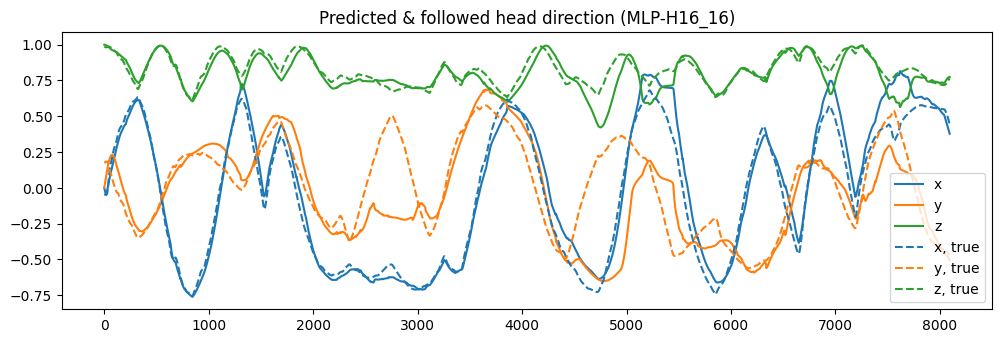

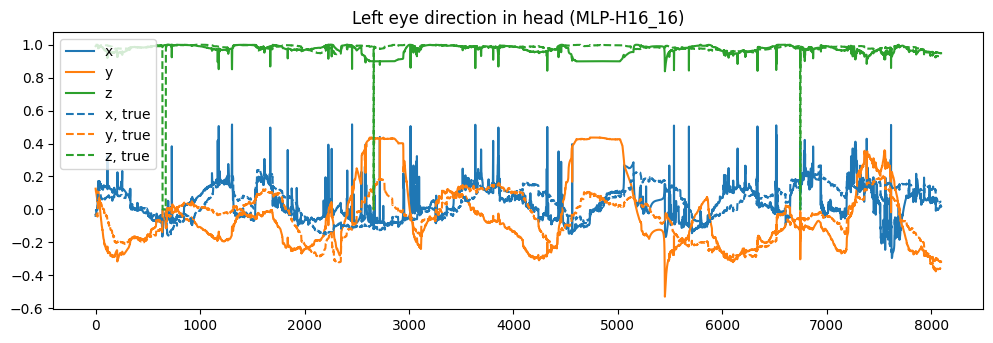

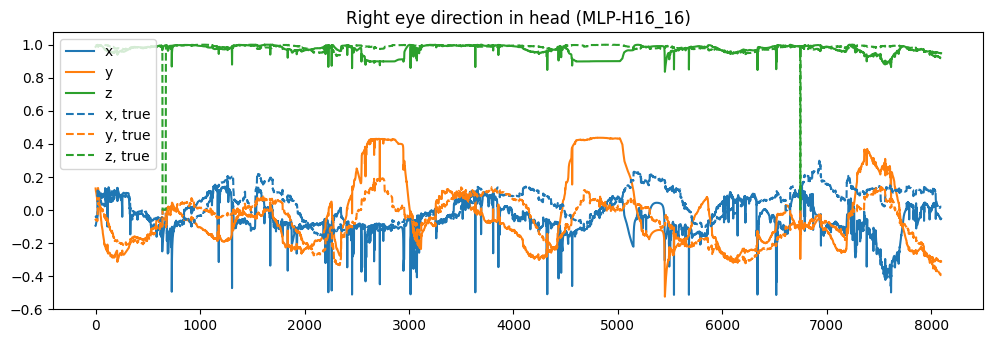

In [36]:
plot_trial(user_task_trajs_mlp2[users[0]][tasks[0]][0], model_name='MLP-H16_16')

### LSTM

In [40]:
lstm = gaze_modeling.GazeLSTM()
load_weights(lstm, 'output/runs/1748539949_lstm_45hz-angle-h_s50/val_best.pth')

user_task_losses_lstm, user_task_trajs_lstm = autoregressive(lstm, downsampling_rate=2)
user_task_losses_lstm

{'2025040302': {'LinearSmoothPursuit': [0.11312798627523016,
   0.11297304686099281,
   0.10183434263993132,
   0.10189377128117663,
   0.13124968507973608,
   0.13119753097095002],
  'ArcSmoothPursuit': [0.12753120791263536,
   0.12737076671974043,
   0.16229440820390917,
   0.16245248943271226,
   0.16912317388054077,
   0.16906422685618597],
  'RapidVisualSearch': [0.28455093737217135,
   0.2839246170092245,
   0.26720328888557804,
   0.2666753036941107,
   0.24758219755809974,
   0.24807414986455742],
  'RapidVisualSearchAvoidance': [0.2810629466971587,
   0.2805322296452281,
   0.27326250244211586,
   0.272887392817562,
   0.27748453786210436,
   0.277899072522068]},
 '2025041602': {'LinearSmoothPursuit': [0.23763703117653787,
   0.23755169581971872,
   0.2887294146161711,
   0.28861866537922537,
   0.23762231700385528,
   0.2374471876440722],
  'ArcSmoothPursuit': [0.24219776563828452,
   0.24238849697439238,
   0.27527715816778997,
   0.27531217181541456,
   0.18826253478797958,

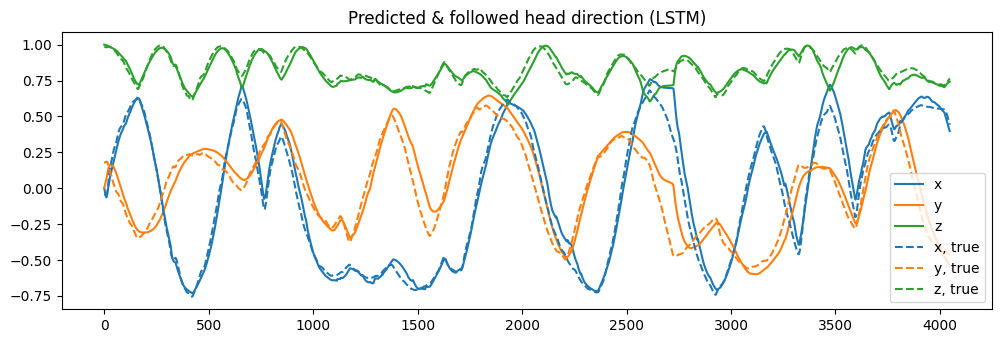

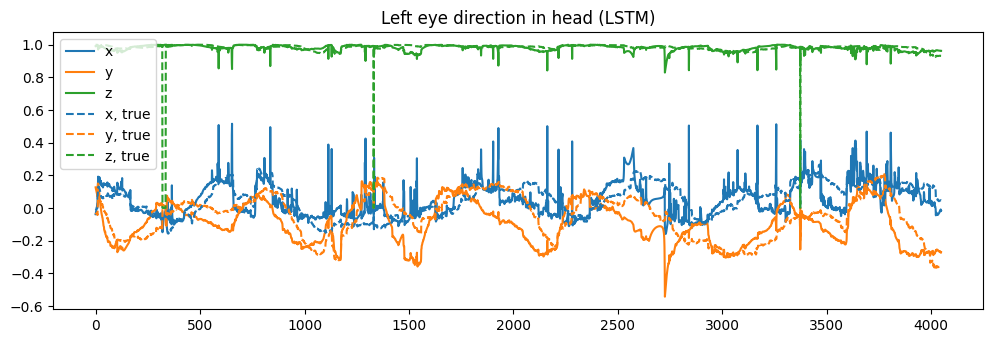

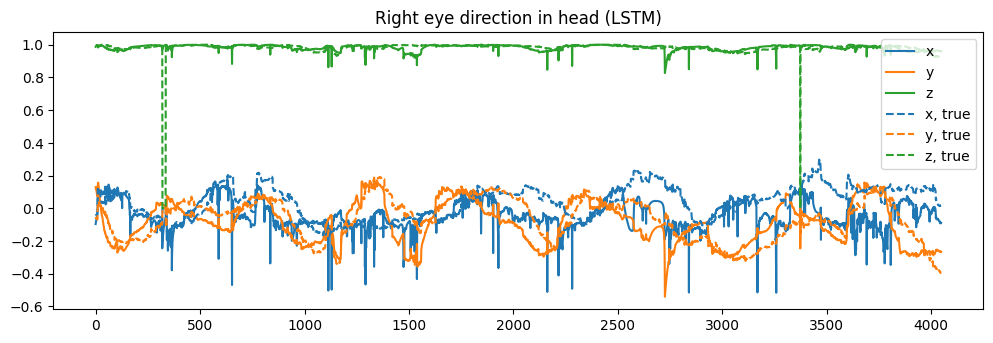

In [41]:
plot_trial(user_task_trajs_lstm[users[0]][tasks[0]][0], model_name='LSTM')

### LSTM-H2

In [42]:
lstm2 = gaze_modeling.GazeLSTM(hidden_sizes=[2])
load_weights(lstm2, 'output/runs/1748541737_lstm_45hz-angle-h2_s50/val_best.pth')

user_task_losses_lstm2, user_task_trajs_lstm2 = autoregressive(lstm2, downsampling_rate=2)
user_task_losses_lstm2

{'2025040302': {'LinearSmoothPursuit': [0.12392449437711288,
   0.1237682405257716,
   0.11597526696753516,
   0.11590185510522664,
   0.12204699009744581,
   0.12204251198879716],
  'ArcSmoothPursuit': [0.12733692334797006,
   0.12721415753257728,
   0.151408644066873,
   0.15137558968981557,
   0.15533299442198673,
   0.155368472138038],
  'RapidVisualSearch': [0.3293929177163355,
   0.3291607418411308,
   0.3146203065680731,
   0.3148484045868675,
   0.28405440245738434,
   0.2839355221379466],
  'RapidVisualSearchAvoidance': [0.32086320166740423,
   0.32070627211977165,
   0.3133841467620359,
   0.3133408949641715,
   0.3215474057826839,
   0.32162233362447723]},
 '2025041602': {'LinearSmoothPursuit': [0.271824584765485,
   0.27175032565192664,
   0.31489558099964,
   0.31479736916518924,
   0.25896675808535624,
   0.2588135575596928],
  'ArcSmoothPursuit': [0.2410654975365923,
   0.24124019442495184,
   0.27332525804266194,
   0.27330984852961043,
   0.18631257967829765,
   0.1863

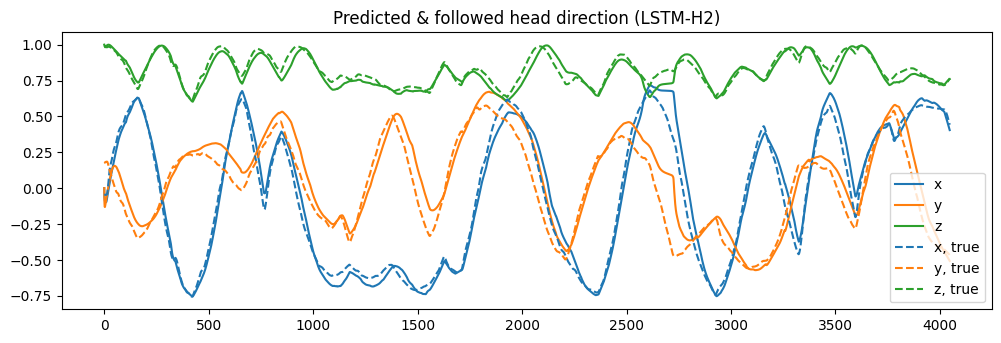

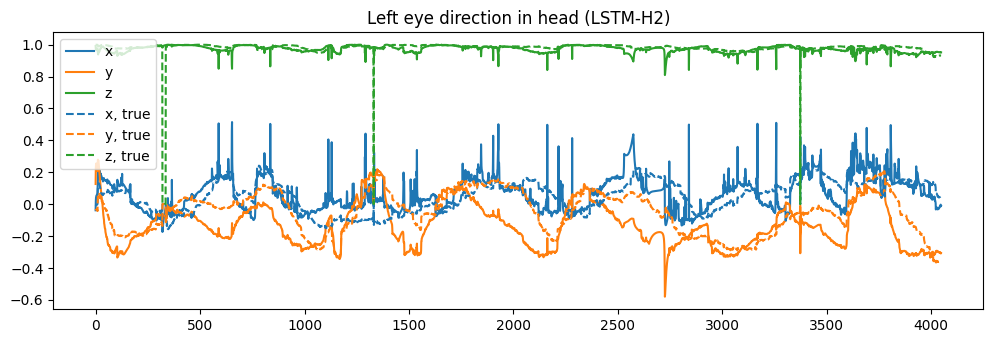

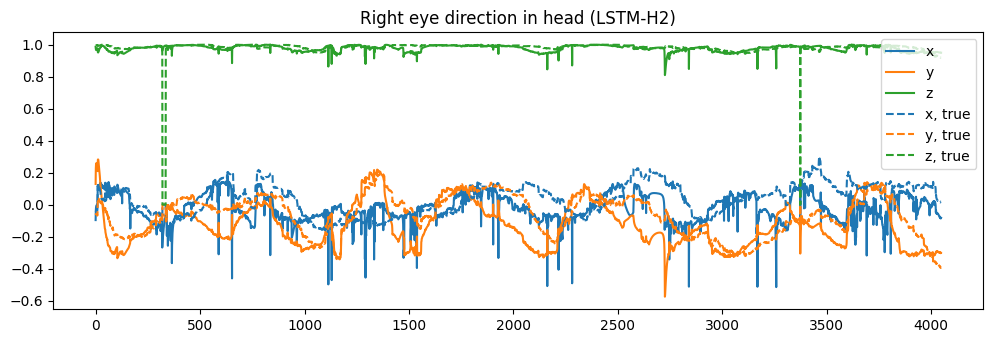

In [43]:
plot_trial(user_task_trajs_lstm2[users[0]][tasks[0]][0], model_name='LSTM-H2')

### LSTM-H16

In [44]:
lstm3 = gaze_modeling.GazeLSTM(hidden_sizes=[16])
load_weights(lstm3, 'output/runs/1748542727_lstm_45hz-angle-h16_s50/val_best.pth')

user_task_losses_lstm3, user_task_trajs_lstm3 = autoregressive(lstm3, downsampling_rate=2)
user_task_losses_lstm3

{'2025040302': {'LinearSmoothPursuit': [1.6034899296930005,
   1.583800136054754,
   1.4977028352167174,
   1.5010099098385719,
   1.1866890500570504,
   1.1303081137347728],
  'ArcSmoothPursuit': [1.7662155834291575,
   1.769022537864701,
   2.1547444924571697,
   2.14459845973485,
   2.002491969241059,
   2.0161915552378313],
  'RapidVisualSearch': [1.3948096060783237,
   1.4563892618382732,
   1.5441249776926402,
   1.5590662051780386,
   1.6361098357695907,
   1.632061609173755],
  'RapidVisualSearchAvoidance': [1.7342535410491557,
   1.6780417705565578,
   1.4076013842522381,
   1.419122945690401,
   1.6236550390350246,
   1.6869686540867623]},
 '2025041602': {'LinearSmoothPursuit': [1.2321335373673121,
   1.1902416095974142,
   1.5653796148183536,
   1.5627404656683614,
   1.0778015398294691,
   1.0671766173802288],
  'ArcSmoothPursuit': [1.7478472033312458,
   1.4685578514547233,
   1.7726346024995132,
   1.6841296721860803,
   1.766914545888299,
   1.6167812574233948],
  'Rapid

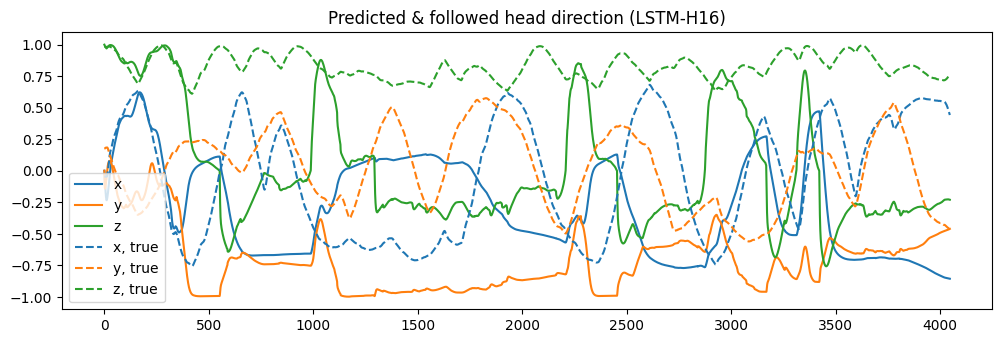

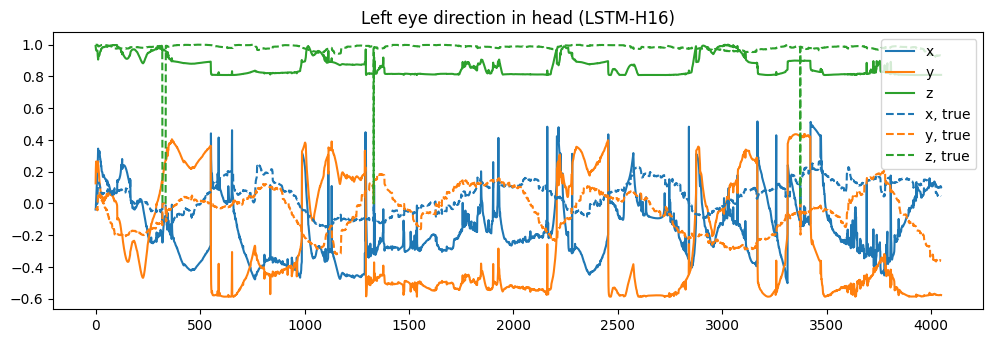

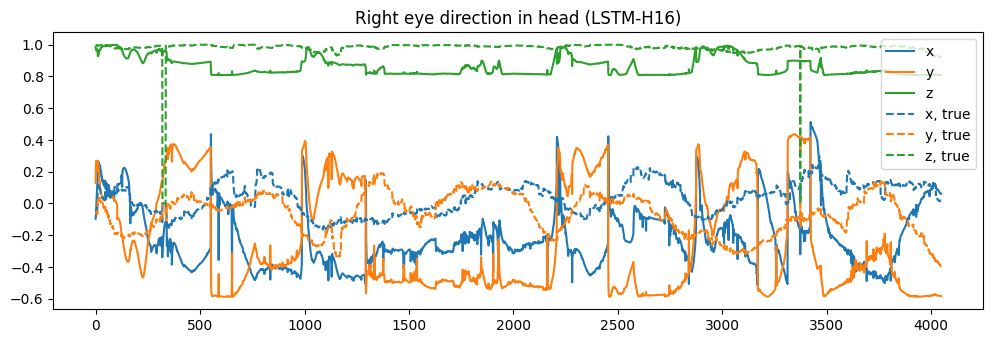

In [45]:
plot_trial(user_task_trajs_lstm3[users[0]][tasks[0]][0], model_name='LSTM-H16')

### LSTM-H128

In [46]:
lstm4 = gaze_modeling.GazeLSTM(hidden_sizes=[128])
load_weights(lstm4, 'output/runs/1748544043_lstm_45hz-angle-h128_s50/val_best.pth')

user_task_losses_lstm4, user_task_trajs_lstm4 = autoregressive(lstm4, downsampling_rate=2)
user_task_losses_lstm4

{'2025040302': {'LinearSmoothPursuit': [2.1834523422625556,
   2.182302761394477,
   2.204609482088081,
   2.2018018908232135,
   2.1404060617992777,
   2.1396447582372207],
  'ArcSmoothPursuit': [2.124624978890033,
   2.124420238014091,
   2.20975280508774,
   2.2129737984884175,
   2.2917804290146715,
   2.2936615862516696],
  'RapidVisualSearch': [2.1113011477195593,
   2.101920687288368,
   2.1293245098849463,
   2.132891581874569,
   2.173095940280952,
   2.1739849455160805],
  'RapidVisualSearchAvoidance': [2.1836336954958613,
   2.185232882445875,
   2.1291689280716843,
   2.126432455102535,
   2.1589356971439386,
   2.157459177911703]},
 '2025041602': {'LinearSmoothPursuit': [2.1661196627643036,
   2.164398935287555,
   2.1759723079440088,
   2.176354179688027,
   2.1167175322150324,
   2.115512989528764],
  'ArcSmoothPursuit': [2.09739348208896,
   2.0980977032202497,
   2.0805522387979405,
   2.081070478032837,
   1.997112602459438,
   1.9951542877838386],
  'RapidVisualSearc

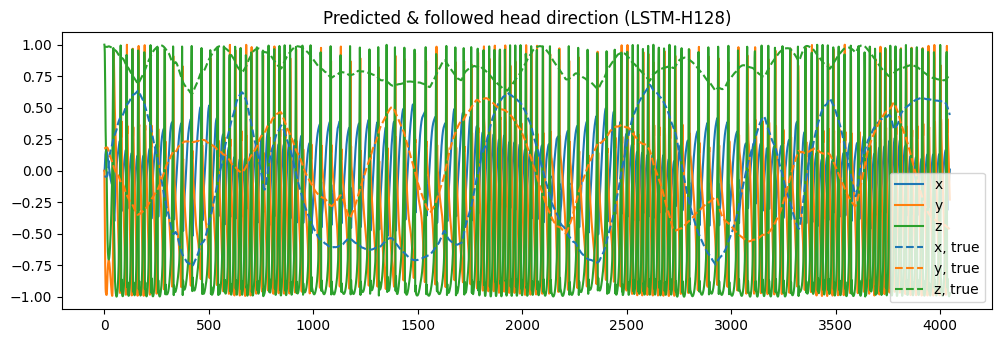

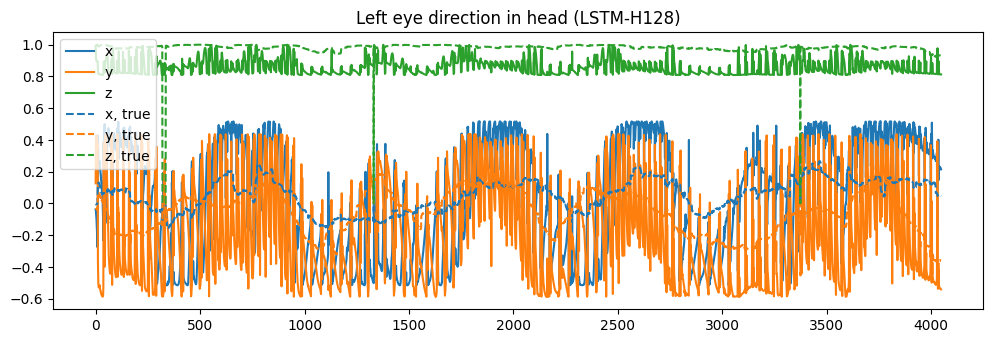

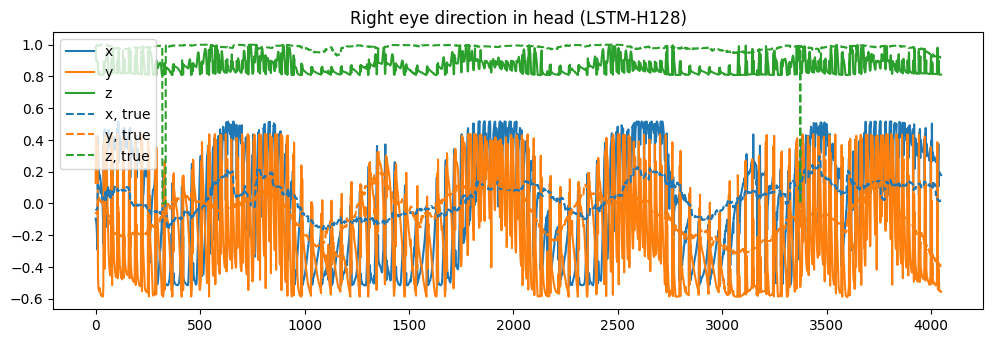

In [47]:
plot_trial(user_task_trajs_lstm4[users[0]][tasks[0]][0], model_name='LSTM-H128')

### Vector (baseline)

In [48]:
vector = gaze_modeling.GazeVectorBaseline()

user_task_losses_vector, user_task_trajs_vector = autoregressive(vector)
user_task_losses_vector

{'2025040302': {'LinearSmoothPursuit': [0.13429752923352758,
   0.12168362580220858,
   0.1666297035417386],
  'ArcSmoothPursuit': [0.18186438477367997,
   0.22131970023520653,
   0.23967480528316742],
  'RapidVisualSearch': [0.2188932779042369,
   0.20433329112926146,
   0.20480781967510858],
  'RapidVisualSearchAvoidance': [0.234863002200822,
   1.6325836031964591,
   0.226439272463595]},
 '2025041602': {'LinearSmoothPursuit': [0.2734951071221042,
   0.32146350153154724,
   0.2676436181289798],
  'ArcSmoothPursuit': [0.2878164788049385,
   0.3109235627471917,
   0.19627096584328135],
  'RapidVisualSearch': [0.2388026467067137,
   0.2517867308837975,
   0.2465176857034692],
  'RapidVisualSearchAvoidance': [0.25184472162179455,
   0.2560803155893006,
   0.25574774167316344]},
 '2025042201': {'LinearSmoothPursuit': [0.11953412723341929,
   0.1349366735470732,
   0.1585743538568988],
  'ArcSmoothPursuit': [0.18641741485171143,
   0.22483927762768707,
   0.16008225414155325],
  'RapidVisu

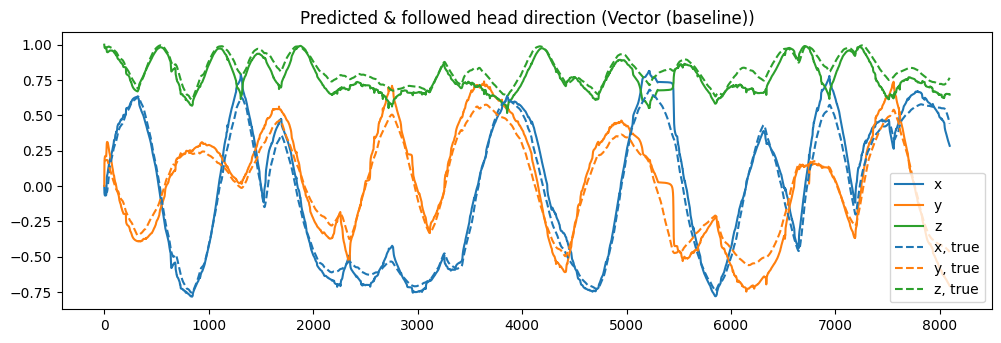

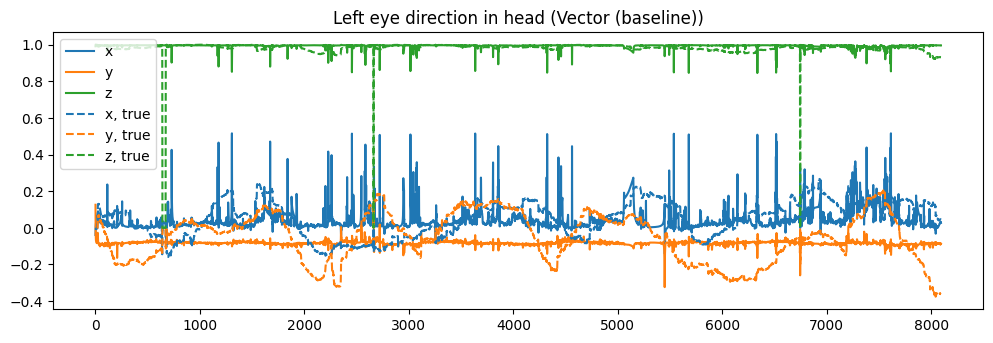

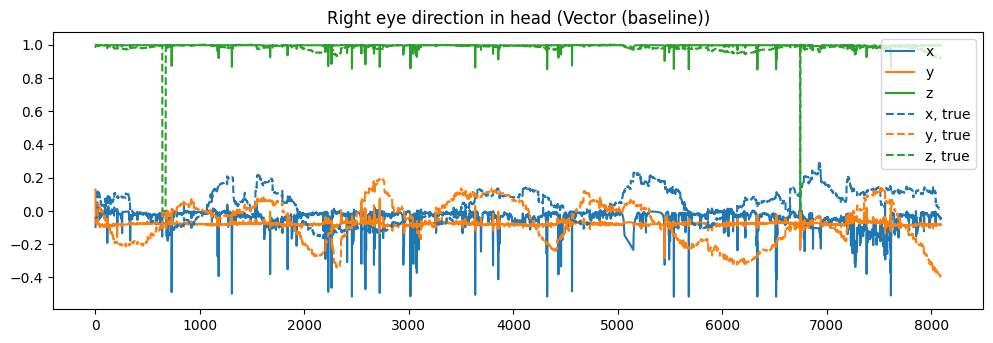

In [49]:
plot_trial(user_task_trajs_vector[users[0]][tasks[0]][0], model_name='Vector (baseline)')

### Vector-P

In [50]:
vectorp = gaze_modeling.GazeVectorParameterized()
load_weights(vectorp, 'output/runs/1748557709_vector-p_s50/val_best.pth')

user_task_losses_vectorp, user_task_trajs_vectorp = autoregressive(vectorp)
user_task_losses_vectorp

{'2025040302': {'LinearSmoothPursuit': [0.18571366378608892,
   0.17183501077981533,
   0.21066404908964928],
  'ArcSmoothPursuit': [0.2057388340800277,
   0.26688941246455644,
   0.25660674642260384],
  'RapidVisualSearch': [0.2624118530021424,
   0.25945550725809874,
   0.2308452056617984],
  'RapidVisualSearchAvoidance': [0.25914991229276,
   0.26316549378184967,
   0.2659475866710467]},
 '2025041602': {'LinearSmoothPursuit': [0.3013583210121664,
   0.3564873493135342,
   0.3037281214419655],
  'ArcSmoothPursuit': [0.3102464327508444,
   0.348255028950861,
   0.21905744976446181],
  'RapidVisualSearch': [0.31294338798855637,
   0.30125183214383444,
   0.30907253126095574],
  'RapidVisualSearchAvoidance': [0.29365164703091595,
   0.2903963541677992,
   0.3073634671203597]},
 '2025042201': {'LinearSmoothPursuit': [0.22513791561284685,
   0.240375752331215,
   0.2497957108502307],
  'ArcSmoothPursuit': [0.24256520860790018,
   0.2925302774057574,
   0.22877847868653128],
  'RapidVisual

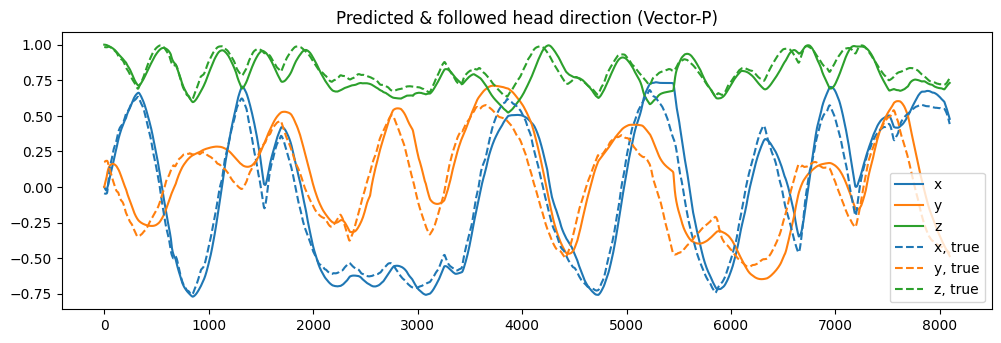

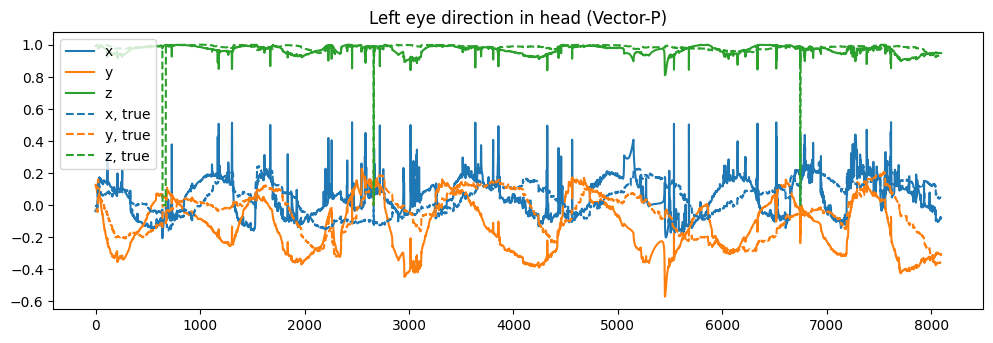

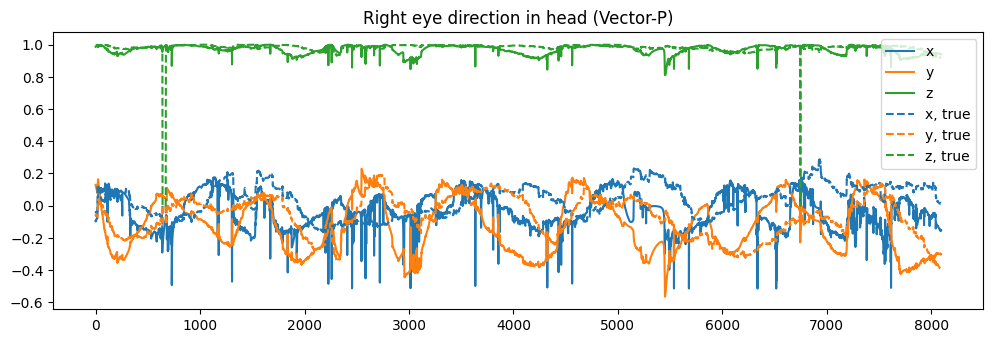

In [51]:
plot_trial(user_task_trajs_vectorp[users[0]][tasks[0]][0], model_name='Vector-P')

## Comparison

In [52]:
models = [mlp, mlp2, lstm, lstm2, lstm3, lstm4, vector, vectorp]
model_names = ['MLP', 'MLP-H16_16', 'LSTM', 'LSTM-H2', 'LSTM-H16', 'LSTM-H128', 'Vector (baseline)', 'Vector-P']
model_user_task_losses = [
    user_task_losses_mlp, user_task_losses_mlp2,
    user_task_losses_lstm, user_task_losses_lstm2,
    user_task_losses_lstm3, user_task_losses_lstm4,
    user_task_losses_vector, user_task_losses_vectorp
]

In [60]:
gap = 0.1
w = (1 - gap) / (len(model_names) + 1)
colors = [f'C{i:d}' for i in range(len(model_names))]

xs = [[start + (gap / 2) + (w * (i + 1)) for i in range(len(model_names))]
      for start in range(len(users))]


def plot_comparison(task):
    plt.figure(figsize=(10.8, 7.2))
    for i in range(len(users)):
        scores = [sum(user_task_losses[users[i]][task]) / len(user_task_losses[users[i]][task]) for user_task_losses in model_user_task_losses]
        plt.bar(xs[i], scores, w - 0.02, color=colors, label=model_names if i == 0 else None)
    plt.title(f'Loss per Model and User - {task}')
    plt.ylabel('Angular Loss (rad)')
    plt.xlabel('User')
    plt.xticks([0.5 + i for i in range(len(users))], users)
    plt.legend()
    plt.show()

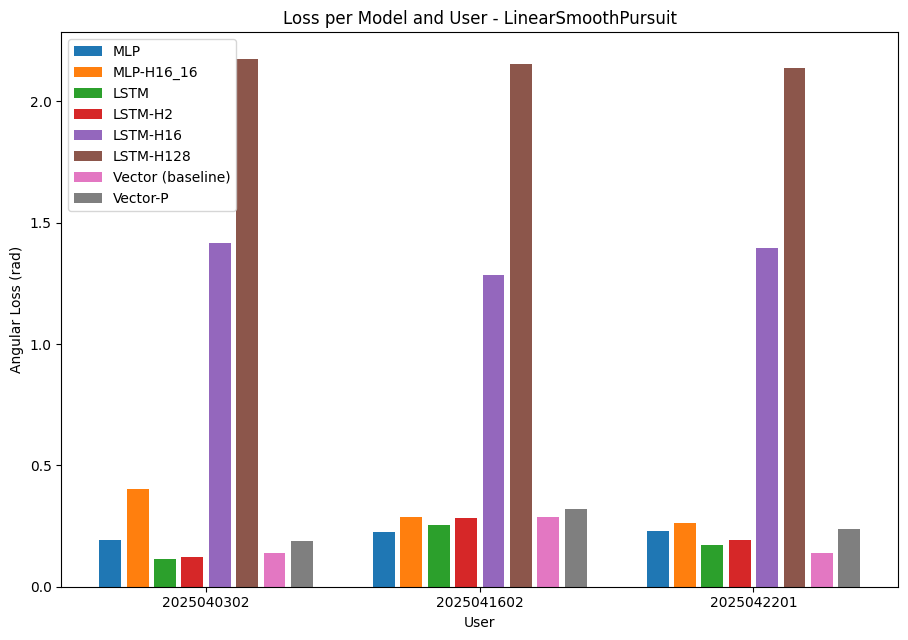

In [61]:
plot_comparison(tasks[0])

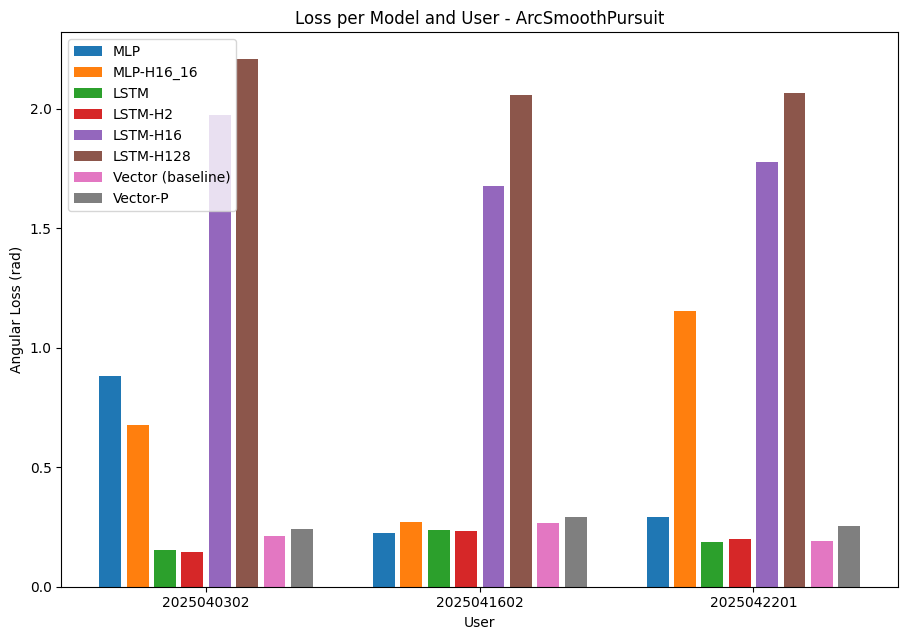

In [62]:
plot_comparison(tasks[1])

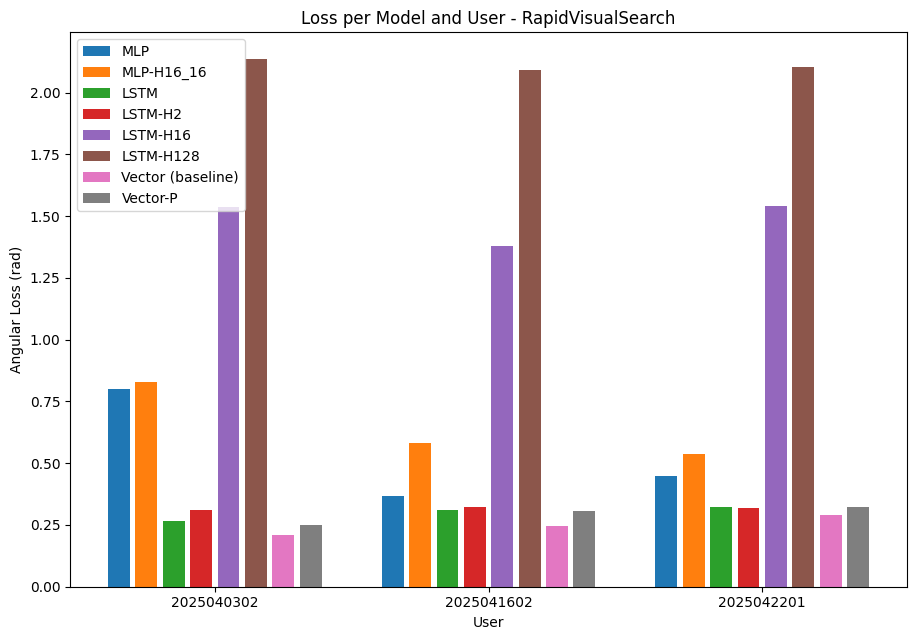

In [63]:
plot_comparison(tasks[2])

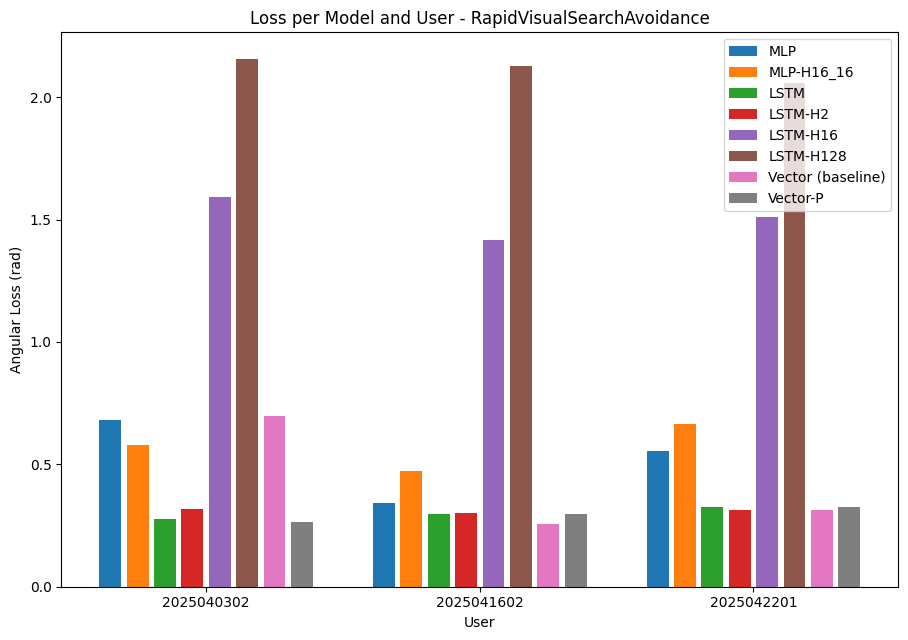

In [64]:
plot_comparison(tasks[3])